In [2]:
#Indicate operating environment
import os
location_input = input("what computer are you on? a = Bens, b = gpucluster, c = other   ")
location_dict = {'a': "C:\\Users\Ben\Documents\GitHub\expression_broad_data", 'b': "/home/heineike/github/expression_broad_data",'c':'you need to add your location to the location_dict'}
base_dir = location_dict[location_input]
print("base directory is " + base_dir)
os.chdir(base_dir) 



what computer are you on? a = Bens, b = gpucluster, c = other   b
base directory is /home/heineike/github/expression_broad_data


In [41]:
from core import expression_plots 
from core import io_library 
# from IPython.core.debugger import Tracer
import numpy as np
import pandas as pd
#import subprocess
import plotly.plotly as py
py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')
from collections import Counter
import scipy.cluster.vq as kmeans
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
# Learn about API authentication here: https://plot.ly/pandas/getting-started
# Find your api_key here: https://plot.ly/settings/api


In [4]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline
%matplotlib notebook

In [5]:
#load kl_sc_PKA_data
kl_sc_PKA_data = pd.read_pickle(base_dir + os.sep + os.path.join("expression_data","kl_PKA_as_20160824","kl_sc_PKA_data"))



In [7]:
#Import Regev data for SCer

# This is the regev raw expression
#   1) It might be interesting to plot it v.s. the RNA seq level data (but counts is not gene expression)
#   2) It would be good to integrate the data into the big dataframe
# #Load raw expression data
# species = 'KLac'
# fname = os.path.normpath(base_dir + "\expression_data\\raw_exp\\"  + species + '_raw_exp.csv')
# raw_exp = pd.read_csv(fname, index_col = 'orf_name')
# print fname + ' raw expression dataset loaded'
# #extract mean expression only
# mean_gene_expression = raw_exp['Mean']
# mean_gene_expression.name = 'mean_gene_expression'

#Load data for microarrays
species = 'KLac'
#Big problem!!! gene names are 10 off for most of the E chromosome because of errors in the microarray.soft file.
#This is solved below but should be a more permanent solution as soon as this dataset is loaded. 

fname = os.path.normpath(base_dir + os.sep + os.path.join("expression_data","GSE36253_Growth", species + "_growth.csv" ))
growth_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print(fname + ' growth microarray dataset loaded')

#group by conditions and take mean
growth_replicate_groups = growth_exp.groupby(axis = 1, level = 'conditions')
growth_exp_avg = growth_replicate_groups.aggregate(np.mean)

fname = os.path.normpath(base_dir + os.sep + os.path.join("expression_data","GSE38478_Stress", species + '_stress.csv' ))
stress_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print(fname + ' stress microarray dataset loaded')

#group by condition and take mean
stress_replicate_groups = stress_exp.groupby(axis = 1, level = 'conditions')
stress_exp_avg = stress_replicate_groups.aggregate(np.mean)

#combine growth and stress average expression datasets. 
if False in stress_exp_avg.index==growth_exp_avg.index:
    print("Error: ID mismatch between condition data. Species = {}".format(species))
condition_arrays_kl = pd.concat([growth_exp_avg,stress_exp_avg], axis = 1)

#gets rid of ID index
condition_arrays_kl.reset_index(level=0, inplace=True)
condition_arrays_kl.index.name = "kl_genename_old" 

#data for microarrays
species = 'SCer'

fname = os.path.normpath(base_dir + os.sep + os.path.join("expression_data","GSE36253_Growth", species + "_growth.csv" ))
growth_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print(fname + ' growth microarray dataset loaded')

#group by conditions and take mean
growth_replicate_groups = growth_exp.groupby(axis = 1, level = 'conditions')
growth_exp_avg = growth_replicate_groups.aggregate(np.mean)

fname = os.path.normpath(base_dir + os.sep + os.path.join("expression_data","GSE38478_Stress", species + '_stress.csv' ))
stress_exp = pd.read_csv(fname,header = [0,1,2], index_col = [0,1])
print(fname + ' stress microarray dataset loaded')

#group by condition and take mean
stress_replicate_groups = stress_exp.groupby(axis = 1, level = 'conditions')
stress_exp_avg = stress_replicate_groups.aggregate(np.mean)

#combine growth and stress average expression datasets. 
if False in stress_exp_avg.index==growth_exp_avg.index:
    print("Error: ID mismatch between condition data. Species = {}".format(species))
condition_arrays_sc = pd.concat([growth_exp_avg,stress_exp_avg], axis = 1)

#gets rid of ID index
condition_arrays_sc.reset_index(level=0, inplace=True)
condition_arrays_sc.index.name = "sc_genename"

/home/heineike/github/expression_broad_data/expression_data/GSE36253_Growth/KLac_growth.csv growth microarray dataset loaded
/home/heineike/github/expression_broad_data/expression_data/GSE38478_Stress/KLac_stress.csv stress microarray dataset loaded
/home/heineike/github/expression_broad_data/expression_data/GSE36253_Growth/SCer_growth.csv growth microarray dataset loaded
/home/heineike/github/expression_broad_data/expression_data/GSE38478_Stress/SCer_stress.csv stress microarray dataset loaded


In [8]:
#Merge SC and KL data based on response to stimulus go term. 

#Load response to stimulus go terms
fname = os.path.normpath(base_dir + os.sep + os.path.join("expression_data","go_terms", "response_to_stimulus_genes.txt" ))
go_resptostim = pd.read_table(fname,header=7) 
go_resptostim.columns = ["sc_genename", "SC_common_name", "Description"]
go_resptostim.set_index("sc_genename", inplace=True)

#Merge SC data onto response to stimulus dataframe
condition_arrays_sc_resptostim = pd.merge(go_resptostim, condition_arrays_sc, how='inner', left_index=True, right_index=True)
#Inner join throws out genes that were not present in microarray
print('Removed genes not present in sc microarray ' + str(set(go_resptostim.index)-set(condition_arrays_sc.index)))


#identifies genes with multiple spots on the microarray
duplicates = [name for (name,count) in Counter(condition_arrays_sc_resptostim.index).items() if count ==2]
print('Removed genes with multiple spots on sc microarray ' + str(duplicates))

#drops those genes, keeping only the first measurment
condition_arrays_sc_resptostim = condition_arrays_sc_resptostim[~condition_arrays_sc_resptostim.index.duplicated(keep='first')]



#Add columns from kl_sc_PKA_data

condition_arrays_sc_resptostim_pka = pd.merge(condition_arrays_sc_resptostim, kl_sc_PKA_data, left_index = True, right_on = 'sc_genename', how='inner')

#drop SC_common_name_y and keep SC_common_name_x
condition_arrays_sc_resptostim_pka.drop("SC_common_name_y", axis = 1, inplace = True)
condition_arrays_sc_resptostim_pka.rename(columns = {'SC_common_name_x' : 'SC_common_name'}, inplace = True)


#fix incorrectly annotated microarray spots (only for resp to stimulus genes)
kl_missing_orfs = list(set(condition_arrays_sc_resptostim_pka['kl_genename']) - set(condition_arrays_kl.index))
print("There are " + str(len(kl_missing_orfs)) + " orfs from the orthologs of the response to stimulus genes missing in the microarray data index, most in E chromosome")
kl_missing_orfs_p10_dict = {gene[0:6] + str.zfill(str(int(gene[6:-1])+10),5) + gene[-1] :gene for gene in kl_missing_orfs}
kl_missing_orfs_p10 = kl_missing_orfs_p10_dict.keys()
kl_still_missing_orfs = list(set(kl_missing_orfs_p10)-set(condition_arrays_kl.index))
print("After adjusting annotations by adding 10 to all missing orfs, there are still " + str(len(kl_still_missing_orfs)) + " missing")
kl_still_missing_orfs_m1_dict = {kl_missing_orfs_p10_dict[badgene][0:6] + str.zfill(str(int(kl_missing_orfs_p10_dict[badgene][6:-1])-1),5) + kl_missing_orfs_p10_dict[badgene][-1] : kl_missing_orfs_p10_dict[badgene] for badgene in kl_still_missing_orfs}
kl_still_missing_orfs_m1_dict 
print("After adjusting annotations by subtractin 1 to the remaining missing orfs, the only missing genes left are: " + str(set(kl_still_missing_orfs_m1_dict.keys())-set(condition_arrays_kl.index)))

kl_genename_new = []
for pot_badgene in condition_arrays_kl.index:
    if pot_badgene in kl_missing_orfs_p10_dict.keys():
        kl_genename_new.append(kl_missing_orfs_p10_dict[pot_badgene])
    elif pot_badgene in kl_still_missing_orfs_m1_dict.keys():
        kl_genename_new.append(kl_still_missing_orfs_m1_dict[pot_badgene])
    else: 
        kl_genename_new.append(pot_badgene) 

condition_arrays_kl['kl_genename'] = kl_genename_new

# Merge in data from kl microarrays
condition_arrays_sc_kl_resptostim_pka = pd.merge(condition_arrays_sc_resptostim_pka,condition_arrays_kl, left_on = 'kl_genename', right_on = 'kl_genename', how = 'inner', suffixes = ('_sc','_kl'))


Removed genes not present in sc microarray {'YHL006C', 'MPR1', 'YER190C-A', 'YML133W-A', 'YDL160C-A', 'YDR014W-A', 'YHR079C-A', 'YNL339W-A', 'YPL283W-A', 'YGR296C-A'}
Removed genes with multiple spots on sc microarray ['YFL007W', 'YBR098W', 'YNL139C']
There are 170 orfs from the orthologs of the response to stimulus genes missing in the microarray data index, most in E chromosome
After adjusting annotations by adding 10 to all missing orfs, there are still 88 missing
After adjusting annotations by subtractin 1 to the remaining missing orfs, the only missing genes left are: {'KLLA0F06830g', 'KLLA0E04862g', 'KLLA0A01308g', 'KLLA0E23870g', 'KLLA0E06600g', 'KLLA0A11208g'}


In [ ]:
condition_arrays_sc_kl_resptostim_pka

In [ ]:
#condition_arrays_sc_resptostim_pka = kl_sc_PKA_data.join(condition_arrays_sc_resptostim, on='sc_genename', how = 'left',lsuffix = '_R',rsuffix = '_R')
#condition_arrays_sc_resptostim_pka = pd.merge(condition_arrays_sc_resptostim, kl_sc_PKA_data, left_index = True, right_on = 'sc_genename', how='inner')


<IPython.core.display.Javascript object>


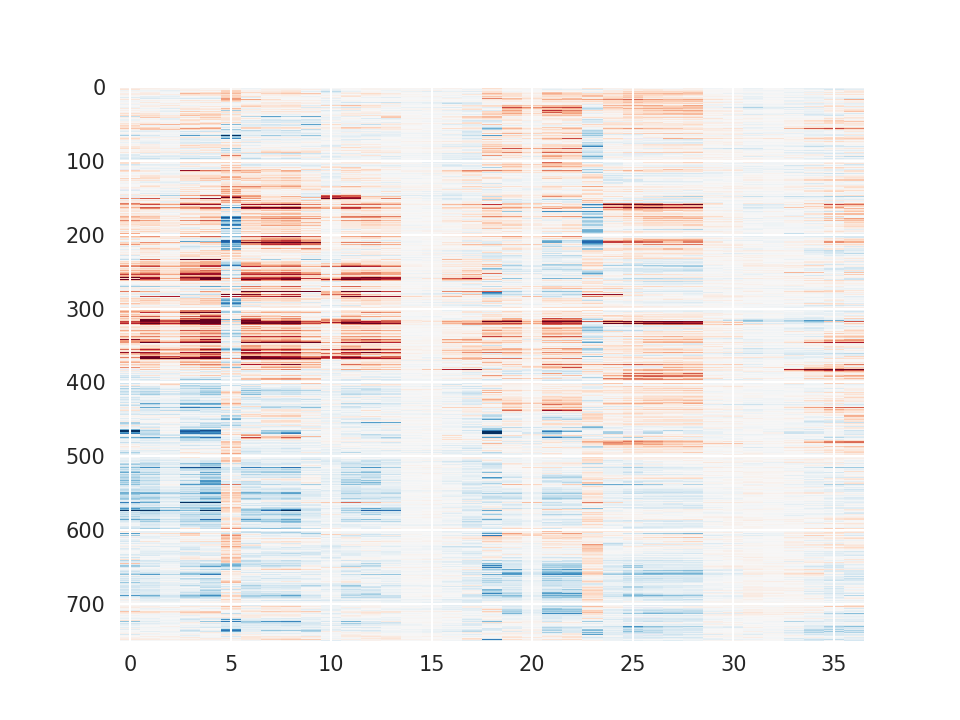

In [40]:
#Heirarchical cluster of stress genes

# # First filter out items with mostly NA values. 
# kl_stress_nmpp1_data_filt = kl_stress_nmpp1_data_col_reorder.dropna(thresh=(len(kl_stress_nmpp1_data_col_reorder.columns)-1))

#Drop out text columns, reorder columns, and reindex on sc_genename for clustering
new_column_order = ['sc_genename', 'SC_PKA(AS)+1NMPP1','DS/LOG_sc',  'LL/LOG_sc', 'PLAT/LOG_sc', 'PS/LOG_sc','LAG/LOG_sc',
       'heat shock_015_sc', 'heat shock_030_sc', 'heat shock_045_sc', 'heat shock_060_sc',
       'NaCl_005_sc', 'NaCl_015_sc', 'NaCl_030_sc', 'NaCl_060_sc',
       'hydrogen peroxide_005_sc', 'hydrogen peroxide_015_sc', 'hydrogen peroxide_030_sc', 'hydrogen peroxide_060_sc',  
       'KL_PKA(AS)+1NMPP1','DS/LOG_kl', 'LL/LOG_kl', 'PLAT/LOG_kl', 'PS/LOG_kl', 'LAG/LOG_kl',
       'heat shock_005_kl', 'heat shock_015_kl','heat shock_030_kl', 'heat shock_045_kl', 'heat shock_060_kl',
       'NaCl_005_kl', 'NaCl_015_kl', 'NaCl_030_kl', 'NaCl_060_kl', 
       'hydrogen peroxide_005_kl', 'hydrogen peroxide_015_kl', 'hydrogen peroxide_030_kl', 'hydrogen peroxide_060_kl']
#resptostim_kl_sc_data = condition_arrays_sc_kl_resptostim_pka.drop(['SC_common_name', 'Description', 'ID_sc','N SCer Orthologs', 'kl_genename',
#       'padj', 'ID_kl'], axis = 1)

resptostim_kl_sc_data = condition_arrays_sc_kl_resptostim_pka[new_column_order]
resptostim_kl_sc_data.set_index('sc_genename', inplace = True) 


resptostim_kl_sc_data_nafill = resptostim_kl_sc_data.fillna(0.0)
resptostim_data_mat = resptostim_kl_sc_data_nafill.as_matrix()

#fig3, ax_cm = plt.subplots()
#ax_cm = sns.clustermap(kl_stress_data_col_reorder_nafill,colcluster = False)
#ax_cm.ax_heatmap.tick_params(labelleft = 'off')

#row_cluster = sch.linkage(resptostim_data_mat, method='average')
row_cluster = sch.linkage(resptostim_data_mat, method='complete', metric = 'correlation')
row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = resptostim_kl_sc_data.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

resptostim_kl_sc_data_reorder = resptostim_kl_sc_data.reindex(new_rows)

fig3, ax3 = plt.subplots()
#ax3= sns.heatmap(kl_stress_nmpp1_data_filt_reorder)
# ax3 = plt.imshow(kl_stress_nmpp1_data_filt_reorder.as_matrix(), cmap='RdBu', vmin=z_min, vmax=z_max,
#            extent=[x.min(), x.max(), y.min(), y.max()],
#            interpolation='nearest', origin='lower')

#use negative value here because the colormap is red to blue - want red to be activation. 
ax3 = plt.imshow(-resptostim_kl_sc_data_reorder.as_matrix(), interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin = -6, vmax = 6)
#plt.axis('off')
#plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\KL_genes.png')

<IPython.core.display.Javascript object>


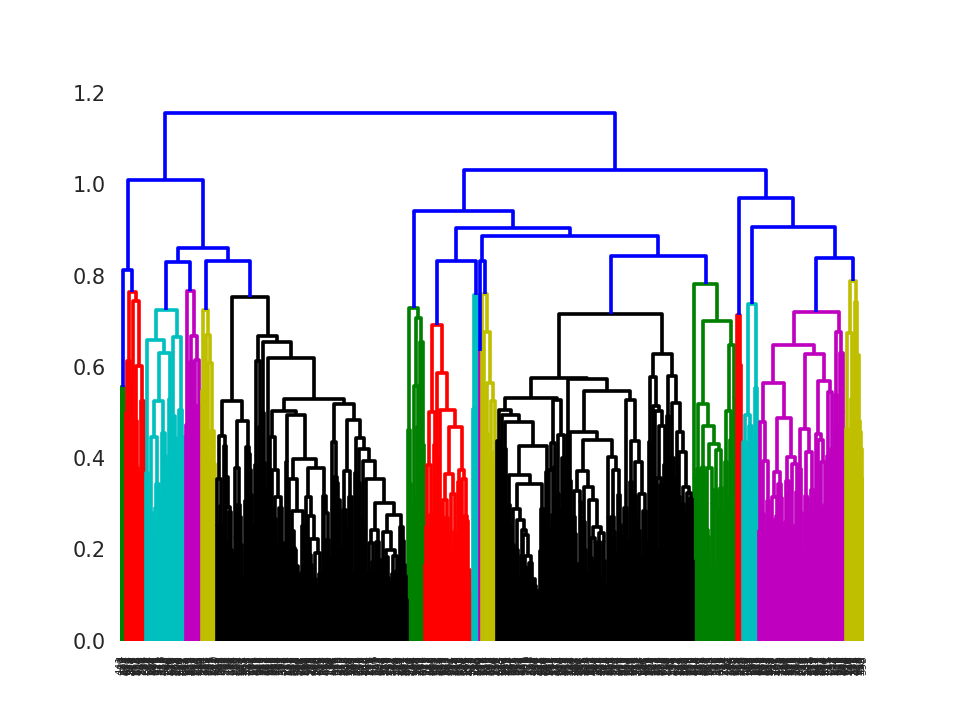

In [39]:
#dendrogram using average algorithm
fig5, ax5 = plt.subplots()
dend = sch.dendrogram(row_cluster)

<IPython.core.display.Javascript object>


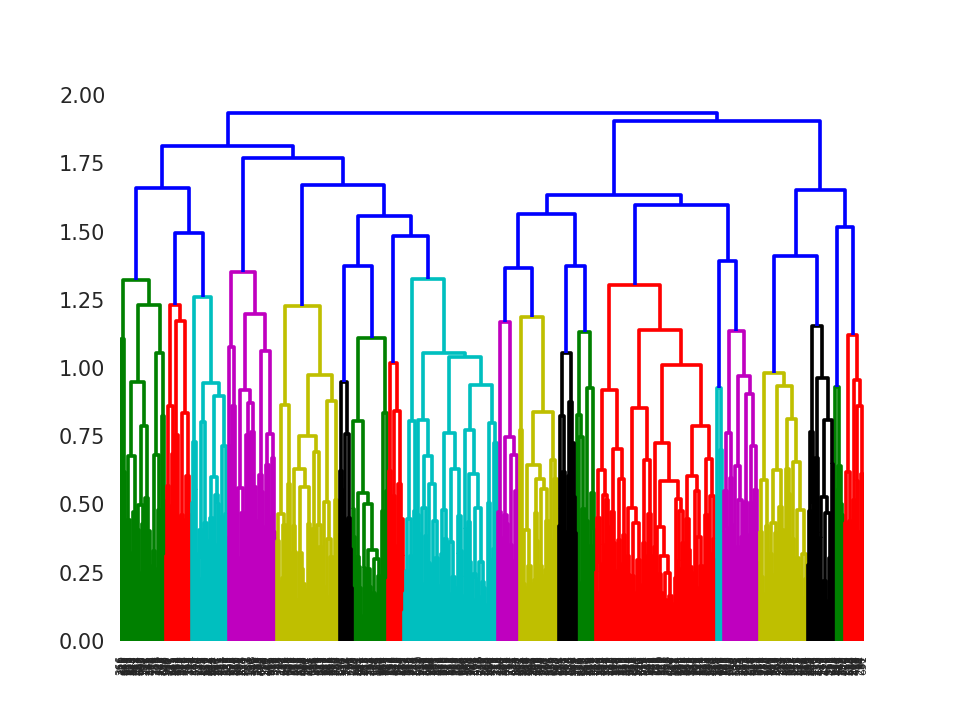

In [37]:
#Dendrogram using complete clustering algorithm
fig4, ax4 = plt.subplots()
dend = sch.dendrogram(row_cluster)


In [35]:
nclusters = sch.fcluster(row_cluster, 16 , criterion = 'maxclust')
nclusters

array([ 4,  2,  2, 11,  1, 15,  5, 15,  2, 11,  7, 14, 11, 11,  5,  7, 11,
        3,  2,  5,  1, 12,  5,  5,  3, 15,  5, 16,  5,  5,  5,  5,  5, 11,
        5,  5, 12, 11,  5,  1, 14,  2,  5, 11, 12, 12,  5, 15, 15, 16,  5,
       15,  5, 14,  5, 11, 11,  4,  5, 15, 12,  7,  7, 12,  6,  5,  5,  5,
        5,  5,  5,  7,  5, 11, 11, 15, 15, 11, 11, 10,  4,  5,  5,  5, 11,
        8,  1, 11, 11, 12,  5,  2, 11, 11,  4, 14,  5, 15, 11,  5,  5, 11,
       11, 11,  5, 14, 11, 11, 15, 16,  5, 11,  5,  7,  3, 11,  2, 11, 11,
       11, 11,  5, 15,  5, 11,  2, 11, 11, 11,  5,  2, 10,  7,  4,  2,  2,
        3,  5, 11, 12,  8, 12, 15, 11,  1,  5, 11, 11,  6,  5,  5, 15, 16,
       11, 11, 11, 15, 15,  2, 12, 11,  5,  7, 11,  7, 15, 10,  5,  5, 11,
       15, 15,  1,  1, 15,  5,  6,  6, 13,  3,  2, 11, 15,  5, 11, 12, 11,
       10,  5, 11, 16,  7, 15,  8,  5,  1,  7, 11,  5, 11, 11,  5,  5,  1,
       11, 15, 11,  5,  5, 11,  5, 11, 11,  7, 11,  5, 11, 11, 11,  7, 15,
       15,  5,  5,  5,  7

In [27]:
row_cluster2
#ax3 = plt.imshow(-resptostim_kl_sc_data_reorder.as_matrix(), interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin = -6, vmax = 6)
len(resptostim_data_mat)


750

In [43]:
kmeans_cluster = kmeans.kmeans2(resptostim_data_mat, 15)

In [53]:
resptostim_kl_sc_data['kmeans_cluster'] = kmeans_cluster[1]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [54]:
resptostim_kl_sc_data

,SC_PKA(AS)+1NMPP1,DS/LOG_sc,LL/LOG_sc,PLAT/LOG_sc,PS/LOG_sc,LAG/LOG_sc,heat shock_015_sc,heat shock_030_sc,heat shock_045_sc,heat shock_060_sc,...,heat shock_060_kl,NaCl_005_kl,NaCl_015_kl,NaCl_030_kl,NaCl_060_kl,hydrogen peroxide_005_kl,hydrogen peroxide_015_kl,hydrogen peroxide_030_kl,hydrogen peroxide_060_kl,kmeans_cluster
sc_genename,,,,,,,,,,,,,,,,,,,,,
YAL013W,0.808994,0.418254,0.065778,0.324663,0.881047,0.459360,0.550652,0.405048,0.542656,-0.306020,...,-0.303386,0.195800,0.194082,-0.140794,-0.093909,-0.080855,-0.596492,-0.834848,-0.384594,8
YAL015C,0.785599,0.839467,0.138346,0.871665,1.526646,-0.403655,1.383676,1.366646,1.644823,0.897463,...,0.030553,-0.238503,-0.079777,0.420574,0.146195,0.494836,1.306365,1.527375,1.585857,1
YOL043C,0.397958,0.359457,-0.046089,0.828633,0.905462,1.597043,0.833989,0.552304,0.729789,0.430873,...,0.030553,-0.238503,-0.079777,0.420574,0.146195,0.494836,1.306365,1.527375,1.585857,14
YAL019W,-3.560320,-2.292419,-0.972677,-1.725544,-3.424110,1.233318,-1.594823,-1.512322,-2.092197,-0.438726,...,-0.804932,-0.163348,-0.077542,0.138856,0.082476,0.202762,0.431322,0.392178,0.329528,6
YAL026C,-0.274260,-0.189335,0.064698,-0.416206,-0.592187,-0.282544,-0.469808,-0.204218,-0.323524,-0.180753,...,-0.522378,-0.094288,-0.045543,0.021648,0.014608,0.174404,-0.318257,-0.286767,0.070312,14
YAL027W,1.008470,0.732662,0.203386,1.129181,1.147902,-0.597116,-0.252126,0.355543,0.262265,-0.066243,...,1.882065,0.245974,0.236396,-0.231951,-0.195074,-0.607548,-0.547822,-0.426353,-0.893325,8
YAL028W,1.656120,2.776052,1.646861,2.314612,3.815209,0.212799,2.427344,1.882901,2.559411,1.346061,...,-0.524403,-0.155181,-0.198036,-0.122801,-0.026420,-1.099451,-0.962084,-0.623665,-0.554689,13
YOR324C,-0.613431,-0.452182,-0.435432,0.327754,-0.098534,1.564185,-0.961858,-0.678943,-0.615902,-0.863858,...,-0.524403,-0.155181,-0.198036,-0.122801,-0.026420,-1.099451,-0.962084,-0.623665,-0.554689,5
YAL053W,-0.043439,-0.037917,0.255458,0.494953,-0.008472,1.014031,0.857477,1.124576,1.030549,0.313837,...,-0.111411,0.079538,-0.023661,-0.341889,-0.250431,-0.156531,-0.240136,-0.280945,-0.319651,14
